Importations

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Parameters of Option

In [6]:
def get_option_type():
    while True:
        option_type = input('Enter the type of the Option (Call or Put): ')
        if option_type.lower() in ['call', 'put']:
            return option_type.capitalize()
        else:
            print("Invalid input. Please enter 'Call' or 'Put'.")

def get_underlying_asset_price():
    while True:
        S = input('Enter the Underlying Asset Price : ')
        try:
            underlying_asset_price = int(S)
            return underlying_asset_price
        except ValueError:
            print("Invalid number type. Please enter an integer number.")

def get_strike_price():
    while True:
        K = input('Enter the Strike Price : ')
        try:
            strike_price = int(K)
            return strike_price
        except ValueError:
            print("Invalid number type. Please enter an integer number.")

def get_maturity():
    while True:
        M = input('Enter the Maturity (in years): ')
        try:
            maturity = float(M)
            if maturity > 0:
                return maturity
            else:
                print("Invalid value. Please enter a positive number.")
        except ValueError:
            print("Invalid number type. Please enter a valid number.")
            
def get_volatility():
    while True:
        vol = input('Enter the Volatility (between 0 and 1): ')
        try:
            volatility = float(vol)
            if 0 <= volatility <= 1:
                return volatility
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_rf():
    while True:
        rf = input('Enter the Risk-Free Interest rate (between 0 and 1): ')
        try:
            risk_free = float(rf)
            if 0 <= risk_free <= 1:
                return risk_free
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")

def get_dividend():
    while True:
        d = input('Enter the Dividend Rate (between 0 and 1): ')
        try:
            div_rate = float(d)
            if 0 <= div_rate <= 1:
                return div_rate
            else:
                print("Invalid value. Please enter a number between 0 and 1.")
        except ValueError:
            print("Invalid number type. Please enter a decimal number between 0 and 1.")


In [10]:
Option_type = get_option_type()
print(f"Option Type: {Option_type}")

S=get_underlying_asset_price()
print(f"Underlying Asset Price: {S} $")

K = get_strike_price()
print(f"Strike Price: {K} $")

T=get_maturity()
print(f"Volatility: {T} years")

volatility = get_volatility()
print(f"Volatility: {volatility*100} %")

r = get_rf()
print(f"Risk-Free: {r*100} %")

q = get_dividend()
print(f"Dividend: {q*100} %")

Option Type: Call
Underlying Asset Price: 100 $
Strike Price: 105 $
Volatility: 1.0 years
Volatility: 20.0 %
Risk-Free: 5.0 %
Dividend: 2.0 %


Binomial Tree

In [14]:
def get_treedepth():
    while True:
        steps = input('Enter the Depth of the Tree (between 0 and 100): ')
        try:
            steps = int(steps)
            if 0 <= steps <= 100:
                return steps
            else:
                print("Invalid value. Please enter a number between 0 and 100.")
        except ValueError:
            print("Invalid number type. Please enter a integer number between 0 and 100.")

In [20]:
N=get_treedepth()
print(f"Depth: {N}")

Depth: 10
Up: 1.07
Down: 0.94


In [107]:
def binomial_tree_method(S, K, T, r, volatility, q, N, Option_type):
    delta_T = T / N
    up = math.exp(volatility * math.sqrt(delta_T))
    down = math.exp(-volatility * math.sqrt(delta_T))
    p = (math.exp((r - q) * delta_T) - down) / (up - down)
    discount_factor = math.exp(-r * delta_T)

    asset_prices = [[0 for _ in range(j + 1)] for j in range(N + 1)]
    option_values = [[0 for _ in range(j + 1)] for j in range(N + 1)]

    # Calculate option values at final time step (N)
    for j in range(N + 1):
        asset_prices[N][j] = S * (up ** j) * (down ** (N - j))
        if Option_type.lower() == 'call':
            option_values[N][j] = max(asset_prices[N][j] - K, 0)
        else:
            option_values[N][j] = max(K - asset_prices[N][j], 0)
            
    # Backward induction to calculate option values at earlier time steps
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            asset_prices[i][j] = S * (up ** j) * (down ** (i - j))
            hold_value = discount_factor * (p * option_values[i + 1][j + 1] + (1 - p) * option_values[i + 1][j])
            if Option_type.lower() == 'call':
                exercise_value = max(asset_prices[i][j] - K, 0)
            else:  
                exercise_value = max(K - asset_prices[i][j], 0)
                
            option_values[i][j] = max(hold_value, exercise_value)

    return option_values[0][0], asset_prices, option_values

In [108]:
def plot_binomial_tree(asset_prices, option_values, option_type):
    N = len(asset_prices) - 1
    G = nx.DiGraph()
    pos = {}
    labels = {}

    for i in range(N + 1):
        for j in range(i + 1):
            G.add_node((i, j))
            pos[(i, j)] = (j - i / 2, i)
            labels[(i, j)] = f'{asset_prices[i][j]:.2f}\n{option_values[i][j]:.2f}'

            if i < N:
                G.add_edge((i, j), (i + 1, j), arrowstyle='->', arrowsize=10)
                G.add_edge((i, j), (i + 1, j + 1), arrowstyle='->', arrowsize=10)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=1500, node_color='lightblue', font_size=8, font_weight='bold', arrows=True)
    plt.title(f'Binomial Tree for {option_type.capitalize()} Option Pricing')
    plt.gca().invert_yaxis()
    plt.show()

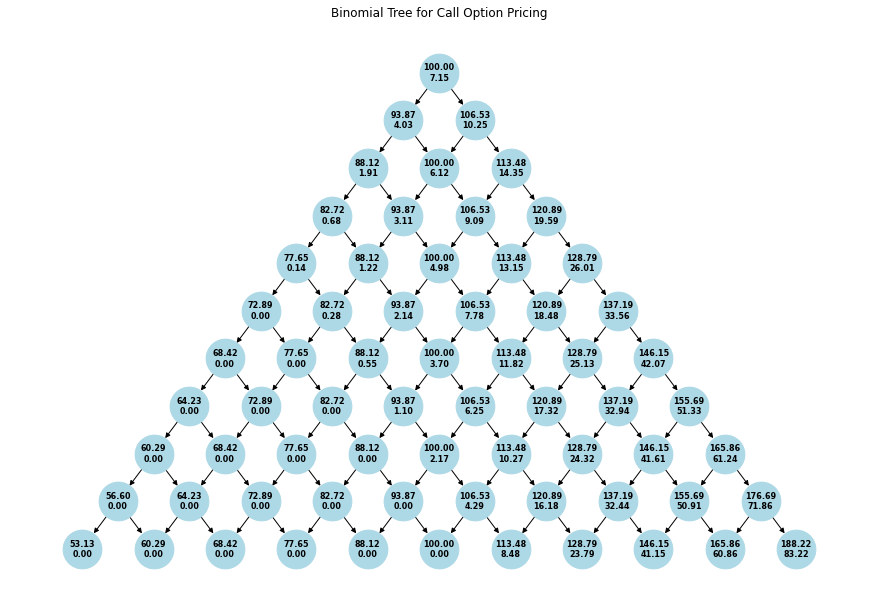

In [109]:
option_value,asset_prices, option_values=binomial_tree_method(S, K, T, r, volatility, q, N, Option_type)
plot_binomial_tree(asset_prices, option_values,Option_type)